# 1. Introduction

In this project, we seek an appropriate algorithm to classify breast tumors as cancerous (malignant) or non-cancerous (benign). Each of the features in this data set comes from a digitized image of a fine needle aspirate (FNA) of a breast mass. The data comes from the Breast Cancer Wisconsin (Diagnostic) data set posted on Kaggle, which can be found here: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data. 

In [18]:
#Load required packages
library(readr)
library(dplyr)
library(ggplot2)
library(corrplot)
library(DescTools)
library(caTools)
library(pROC)
library(class)
library(randomForest)

In [5]:
#Load the data file
raw_bc_data <- read_csv("Breast Cancer Data.csv")
head(raw_bc_data)

Parsed with column specification:
cols(
  .default = col_double(),
  diagnosis = col_character()
)

See spec(...) for full column specifications.



id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


The data set has 32 variables, including a variety of different tumor characteristics. The id variable is not very useful for us, so we remove it in the next step. The diagnosis variable is the dependent variable in our analysis, so we will transform it from a character to a factor variable.  

In [6]:
#Remove first column, turn diagnosis into a factor
bc_data <- raw_bc_data[,-1]
bc_data$diagnosis <- as.factor(bc_data$diagnosis)

# 2. Exploratory Data Analysis

Next we turn to exploratory analysis of the data. We start by checking for missing values and generating simple summary statistics.

In [7]:
#Check for missing values
sapply(bc_data, function(x) sum(is.na(x)))

#Obtain summary statistics
summary(bc_data)

diagnosis             radius_mean            texture_mean 
                      0                       0                       0 
         perimeter_mean               area_mean         smoothness_mean 
                      0                       0                       0 
       compactness_mean          concavity_mean     concave_points_mean 
                      0                       0                       0 
          symmetry_mean  fractal_dimension_mean               radius_se 
                      0                       0                       0 
             texture_se            perimeter_se                 area_se 
                      0                       0                       0 
          smoothness_se          compactness_se            concavity_se 
                      0                       0                       0 
      concave_points_se             symmetry_se    fractal_dimension_se 
                      0                       0                       0 
           radius_worst           texture_worst         perimeter_worst 
                      0                       0                       0 
             area_worst        smoothness_worst       compactness_worst 
                      0                       0                       0 
        concavity_worst    concave_points_worst          symmetry_worst 
                      0                       0                       0 
fractal_dimension_worst 
                      0

 diagnosis  radius_mean      texture_mean   perimeter_mean     area_mean     
 B:357     Min.   : 6.981   Min.   : 9.71   Min.   : 43.79   Min.   : 143.5  
 M:212     1st Qu.:11.700   1st Qu.:16.17   1st Qu.: 75.17   1st Qu.: 420.3  
           Median :13.370   Median :18.84   Median : 86.24   Median : 551.1  
           Mean   :14.127   Mean   :19.29   Mean   : 91.97   Mean   : 654.9  
           3rd Qu.:15.780   3rd Qu.:21.80   3rd Qu.:104.10   3rd Qu.: 782.7  
           Max.   :28.110   Max.   :39.28   Max.   :188.50   Max.   :2501.0  
 smoothness_mean   compactness_mean  concavity_mean    concave_points_mean
 Min.   :0.05263   Min.   :0.01938   Min.   :0.00000   Min.   :0.00000    
 1st Qu.:0.08637   1st Qu.:0.06492   1st Qu.:0.02956   1st Qu.:0.02031    
 Median :0.09587   Median :0.09263   Median :0.06154   Median :0.03350    
 Mean   :0.09636   Mean   :0.10434   Mean   :0.08880   Mean   :0.04892    
 3rd Qu.:0.10530   3rd Qu.:0.13040   3rd Qu.:0.13070   3rd Qu.:0.07400    
 Max

As shown above, there is no missing data. The scales of some variables differ by several orders of magnitude, so it will be helpful to normalize the data before performing classification. Next we examine the balance of categories of the outcome variable (diagnosis).

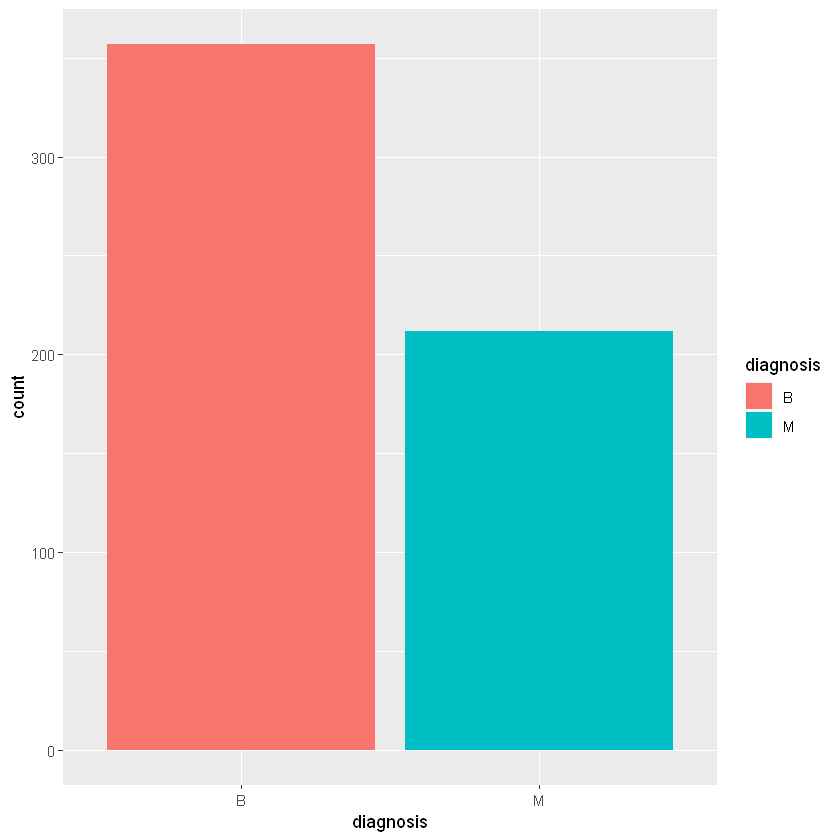

In [8]:
#Bar chart of benign vs. malignant
plot_1 <- ggplot(bc_data, aes(x = diagnosis, fill = diagnosis)) +
  geom_bar()
plot_1

We can see that there are more benign than malignant tumors, but the categories are not so imbalanced as to warrant a non-standard analysis technique. 

Now we examine the correlations between the various tumor characteristics. The plot below shows the correlations between each set of predictors in the data set. The dark blue circles indicate that many of the variables are highly correlated. This could negatively impact the accuracy of our classification algorithms, so we will handle this problem in the next step of our analysis.

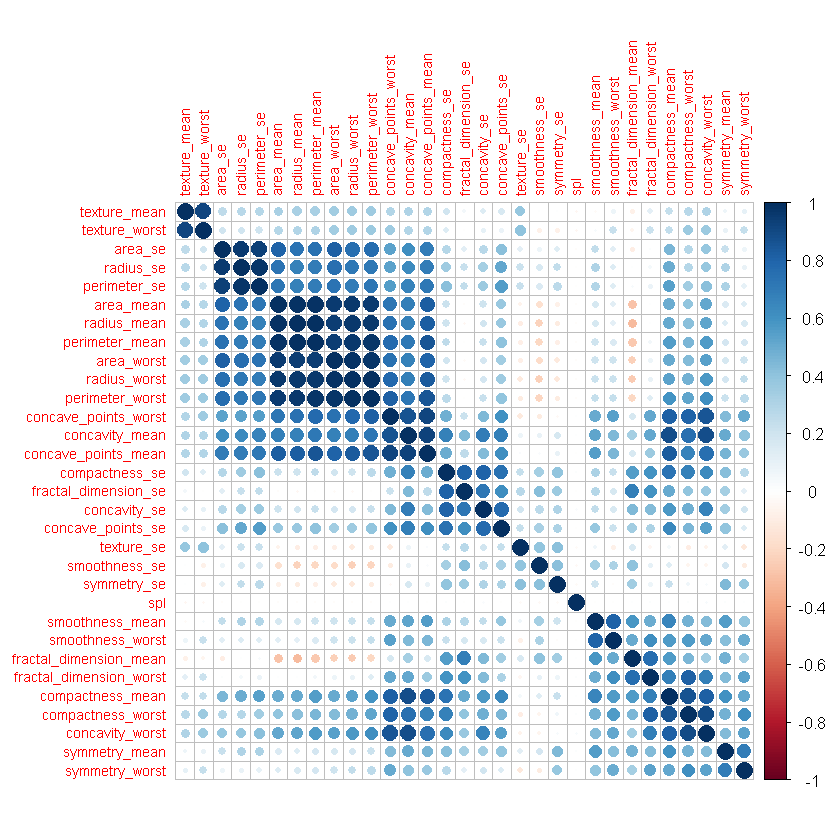

In [19]:
#Examining correlations between factors
M <- cor(bc_data[, -1])
corrplot(M, method = "circle", tl.cex=0.7, order="hclust")

# 3. PCA Transformation

The exploratory analysis above reveals two main issues with the data: the values of the features are on very different scales and there is a high degree of multicollinearity between many of the predictors. To deal with both problems at once, we implement principal component analysis (PCA). PCA is a technique for reducing the dimensionality of data while simultaneously minimizing information loss. It does so by using creating a set of linear combinations of the original variables that are uncorrelated and successively maximize variance. PCA can also be used for feature normalization, meaning that the values of each of the resulting principal components are on the same scale. The downside of this transformation is that we can no longer identify the relative importance of the original predictors to the resulting model. Because our goal is simply to produce an accurate classifier, we are willing accept this tradeoff and proceed with a PCA transformation.

Before applying PCA, we break the data into training and test sets. We use 2/3 of the data to train our models, and the other 1/3 to test the accuracy of each classifier.

In [20]:
#Break data into training and test sets
set.seed(42)
bc_data$spl <- sample.split(bc_data$diagnosis)
bc_data_train <- bc_data %>% filter(spl == "TRUE")
bc_data_test <- bc_data %>% filter(spl == "FALSE")

#Prepare training and test data for PCA. Use all rows but "diagnosis" in wisc_data, set "diagnosis" as a separate vector.
diagnosis_train <- bc_data_train$diagnosis
diagnosis_test <- bc_data_test$diagnosis
wisc_data_train <- bc_data_train[,-c(1,32)]
wisc_data_test <- bc_data_test[,-c(1,32)]

#Run PCA to reduce dimension of the training set and normalize features
wisc_pr_train <- prcomp(wisc_data_train, center = TRUE, scale = TRUE)
summary(wisc_pr_train)

Importance of components:
                          PC1    PC2     PC3     PC4    PC5     PC6     PC7
Standard deviation     3.5718 2.4374 1.70866 1.42629 1.3030 1.13910 0.80269
Proportion of Variance 0.4253 0.1980 0.09732 0.06781 0.0566 0.04325 0.02148
Cumulative Proportion  0.4253 0.6233 0.72062 0.78843 0.8450 0.88827 0.90975
                          PC8     PC9    PC10    PC11    PC12    PC13   PC14
Standard deviation     0.6730 0.65909 0.61414 0.56990 0.51852 0.45705 0.4063
Proportion of Variance 0.0151 0.01448 0.01257 0.01083 0.00896 0.00696 0.0055
Cumulative Proportion  0.9248 0.93933 0.95190 0.96273 0.97169 0.97865 0.9841
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.29593 0.27837 0.23574 0.22158 0.20643 0.17669 0.17419
Proportion of Variance 0.00292 0.00258 0.00185 0.00164 0.00142 0.00104 0.00101
Cumulative Proportion  0.98707 0.98966 0.99151 0.99315 0.99457 0.99561 0.99662
                         PC22    PC23    PC24 

After using PCA, we must choose the number of principal components to use as predictors for our classifiers. We decide to use the first seven principal components, because together they capture over 90% of the variance of the original data. Thus our data set is reduced from 30 predictors to seven, while retaining most of the variance of the original data set. As mentioned above, this transformation comes with the tradeoff of interpretability, as we can no longer see the impact of each original variable to the predictions of the classification algorithms.

In the next step, we use the same PCA transformation used on the training data to transform the test data. Then we add the diagnosis vector from the original data set to the new PCA-transformed training and test sets. Now we are prepared to attempt our first model, logistic regression.

In [11]:
#Transform the test data using the PCA function from training data
wisc_pr_test <- predict(wisc_pr_train, wisc_data_test)
wisc_pr_test <- as_tibble(wisc_pr_test) %>% select(PC1:PC7)
wisc_pr_train <- as_tibble(wisc_pr_train$x) %>% select(PC1:PC7)

#Combine diagnosis vector to principal components matrix
wisc_pr_train$diagnosis <- diagnosis_train
wisc_pr_test$diagnosis <- diagnosis_test

# 4. Logistic Regression

After transforming the data, we proceed with fitting a logistic regression model to the training data using the first seven principal components as predictors.

In [12]:
#Logistic regression with remaining variables
summary(log_model <- glm(diagnosis ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7, family = "binomial", data = wisc_pr_train))

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = diagnosis ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + 
    PC7, family = "binomial", data = wisc_pr_train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.51021  -0.02409  -0.00152   0.00034   2.73132  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.03034    0.51798  -1.989 0.046685 *  
PC1         -3.33100    0.67358  -4.945 7.61e-07 ***
PC2          1.95512    0.50983   3.835 0.000126 ***
PC3         -0.83151    0.33774  -2.462 0.013818 *  
PC4         -1.12065    0.31356  -3.574 0.000352 ***
PC5          2.10107    0.67682   3.104 0.001907 ** 
PC6         -0.07607    0.31783  -0.239 0.810831    
PC7          0.22540    0.64093   0.352 0.725084    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 500.301  on 378  degrees of freedom
Residual deviance:  47.227  on 371  degrees of freedom
AIC: 63.227

Number of Fis

As the warning message above indicates, there is an issue with complete or quasi-complete separation in the data. This generally leads to inflated coefficient estimates and standard errors. The PCA transformation makes coefficient interpretation meaningless anyway, so this should not impact our analysis. In some cases, separation can cause a poor fit to unseen data, so we will test the model on the test data to see if this is a problem.

It is important to note that rather than predicting the class to which an observation belongs, the model outputs the estimated probability of a response. In this case, our model does not predict whether a given tumor is benign or malignant, it simply computes the estimated probability that the tumor is malignant. To transform this into a prediction, we must choose a cutoff or threshold value. Tumors assigned a probability above the threshold value are classified as malignant, while tumors with probabilities below this value are classified as benign. For simplicity, we set a threshold value of 0.5.

         
predicted   B   M
        0 119   6
        1   0  65

[1] 0.9684211

Setting levels: control = B, case = M

Setting direction: controls < cases




Call:
roc.default(response = wisc_pr_test$diagnosis, predictor = predicted,     percent = TRUE, plot = TRUE, legacy.axes = TRUE, xlab = "False Positive Percentage",     ylab = "True Positive Percentage", col = "#377eb8", lwd = 4,     print.auc = TRUE)

Data: predicted in 119 controls (wisc_pr_test$diagnosis B) < 71 cases (wisc_pr_test$diagnosis M).
Area under the curve: 95.77%

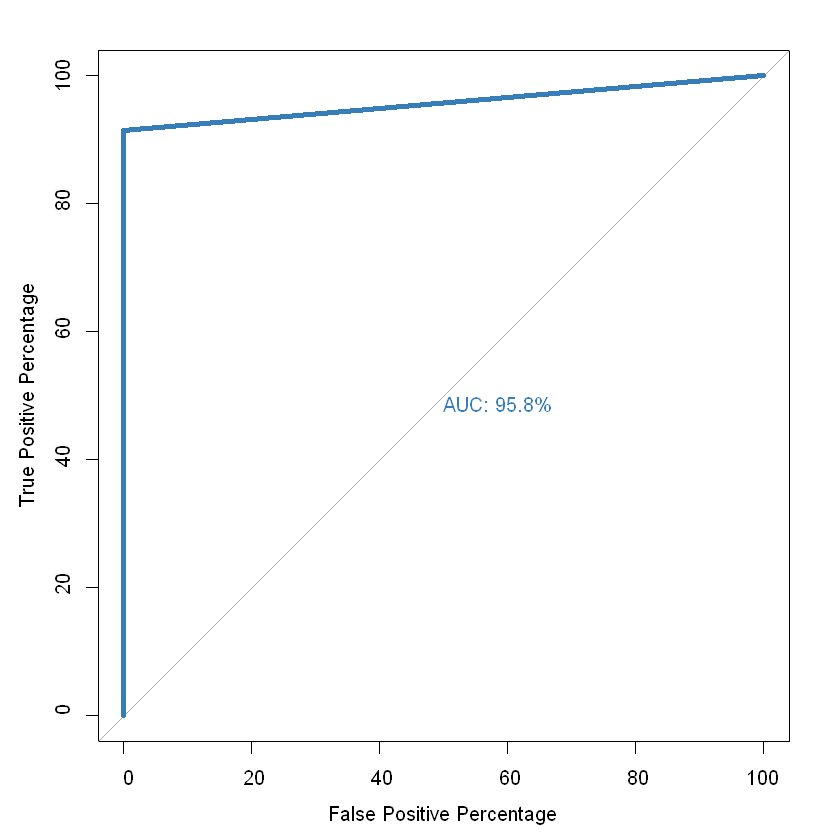

In [22]:
#Computing accuracy on the test set
predicted <- predict(log_model, wisc_pr_test[,1:7], type = "response")
predicted <- ifelse(predicted > 0.5, 1, 0)
d <- table(predicted, wisc_pr_test$diagnosis)
d
sum(diag(d))/sum(d)

#Plot ROC curve
par(pty = "s")
roc(wisc_pr_test$diagnosis, predicted, plot = TRUE, legacy.axes = TRUE, percent = TRUE,
    xlab = "False Positive Percentage", ylab = "True Positive Percentage", col = "#377eb8", lwd = 4,
    print.auc = TRUE)

The logistic regression model correctly classifies 96.8% of the observations in the test data. This impressive performance mitigates our worries about separation in the data.

The ROC curve for the model is shown above. This curve shows us how well the model performs at distinguishing between the two classes on a scale of 0% to 100%, where 100% represents perfect discrimination. An AUC value of 95.8% tells us that the model is very effective at distinguishing malignant and benign cases.

Next, we will try a k-nearest neighbors (kNN) model to see if we can improve on this performance.

# 5. kNN

kNN is a common classification tool for supervised learning. We start by training the algorithm with our training data that has already been classified into benign and malignant categories. For a given test case, the algorithm calculates the Euclidean distance between the test case and each of the training examples to identify the closest k points to the test case. The test case is then classified as belonging to the category to which a majority of the k nearest neighbors belong. A simple example may be illustrative: If k = 11, the algorithm identifies the 11 nearest points to a given test case. If 7 of these points are classified as benign and 4 are classified as malignant, the test case is predicted to be benign.

A common rule of thumb is to run kNN with k = $\sqrt{N}$, where N is the number of observations in the training set. We have 379 observations in the training set, so we follow this convention and use a k value of 19. Once again, we use the PCA-transformed data to produce the model, as non-normalized data could be problematic for classification.

        
wisc_knn   B   M
       B 118  10
       M   1  61

[1] 0.9421053

Setting levels: control = B, case = M

Setting direction: controls < cases




Call:
roc.default(response = wisc_pr_test$diagnosis, predictor = as.numeric(wisc_knn),     percent = TRUE, plot = TRUE, legacy.axes = TRUE, xlab = "False Positive Percentage",     ylab = "True Positive Percentage", col = "#4daf4a", lwd = 4,     print.auc = TRUE)

Data: as.numeric(wisc_knn) in 119 controls (wisc_pr_test$diagnosis B) < 71 cases (wisc_pr_test$diagnosis M).
Area under the curve: 92.54%

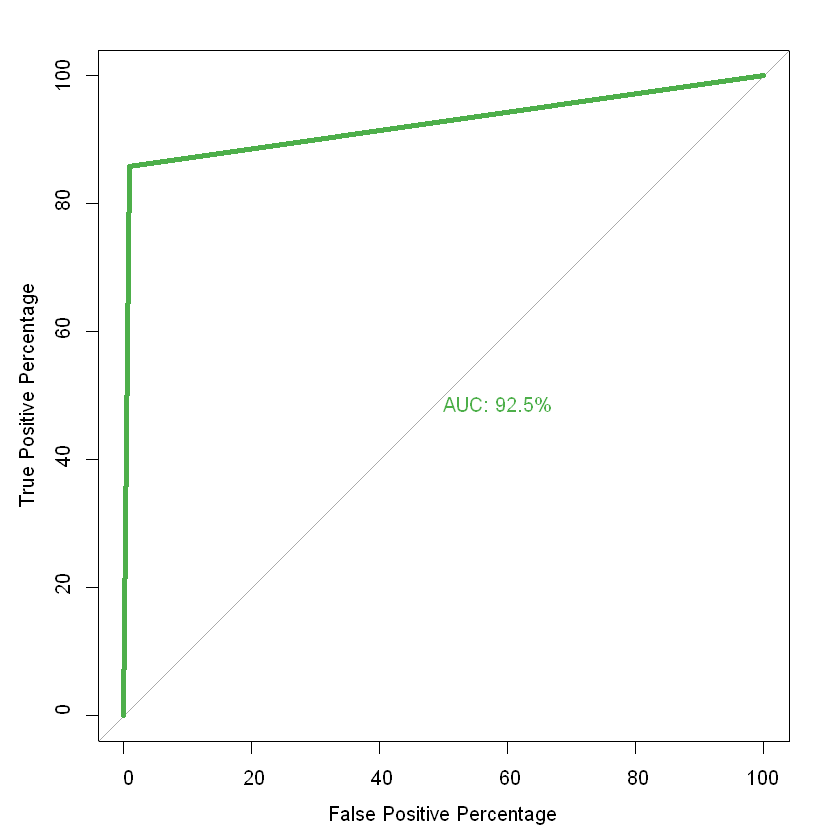

In [14]:
#Run the kNN model
set.seed(42)
wisc_knn <- knn(wisc_pr_train[,1:7], wisc_pr_test[,1:7], cl = diagnosis_train, k = 19)
f <- table(wisc_knn, wisc_pr_test$diagnosis)
f
sum(diag(f))/sum(f)

#Plot ROC curve
par(pty = "s")
roc(wisc_pr_test$diagnosis, as.numeric(wisc_knn), plot = TRUE, legacy.axes = TRUE, percent = TRUE,
    xlab = "False Positive Percentage", ylab = "True Positive Percentage", col = "#4daf4a", lwd = 4,
    print.auc = TRUE)

The kNN algorithm correctly classifies 94.2% of the observations in the test data, with an AUC value of 92.5%. Lastly, we turn to a random forest classifier.

# 6. Random Forest

The random forest is an ensemble tree-based learning algorithm capable of performing both regression and classification tasks. Put simply, the algorithm builds many decision trees and merges them together to produce a more accurate and stable prediction. Each decision tree uses a subset of the predictor variables and training observations to predict the class of a new test example. The predictions of each tree are then averaged together to create an aggregate prediction that is used to classify the new observation.

We choose to use 300 trees, as this value minimizes the out-of-bag (OOB) error rate estimate. This means that using 300 trees is likely to minimize the error rate when the algorithm attempts to classify new unseen data. As the code shows below, the OOB error rate estimate is 5.28%. 


Call:
 randomForest(formula = diagnosis ~ PC1 + PC2 + PC3 + PC4 + PC5 +      PC6 + PC7, data = wisc_pr_train, ntree = 300) 
               Type of random forest: classification
                     Number of trees: 300
No. of variables tried at each split: 2

        OOB estimate of  error rate: 5.28%
Confusion matrix:
    B   M class.error
B 228  10  0.04201681
M  10 131  0.07092199

          
rf_predict   B   M
         B 116   5
         M   3  66

[1] 0.9578947

Setting levels: control = B, case = M

Setting direction: controls < cases




Call:
roc.default(response = wisc_pr_test$diagnosis, predictor = as.numeric(rf_predict),     percent = TRUE, plot = TRUE, legacy.axes = TRUE, xlab = "False Positive Percentage",     ylab = "True Positive Percentage", col = "#e34a33", lwd = 4,     print.auc = TRUE)

Data: as.numeric(rf_predict) in 119 controls (wisc_pr_test$diagnosis B) < 71 cases (wisc_pr_test$diagnosis M).
Area under the curve: 95.22%

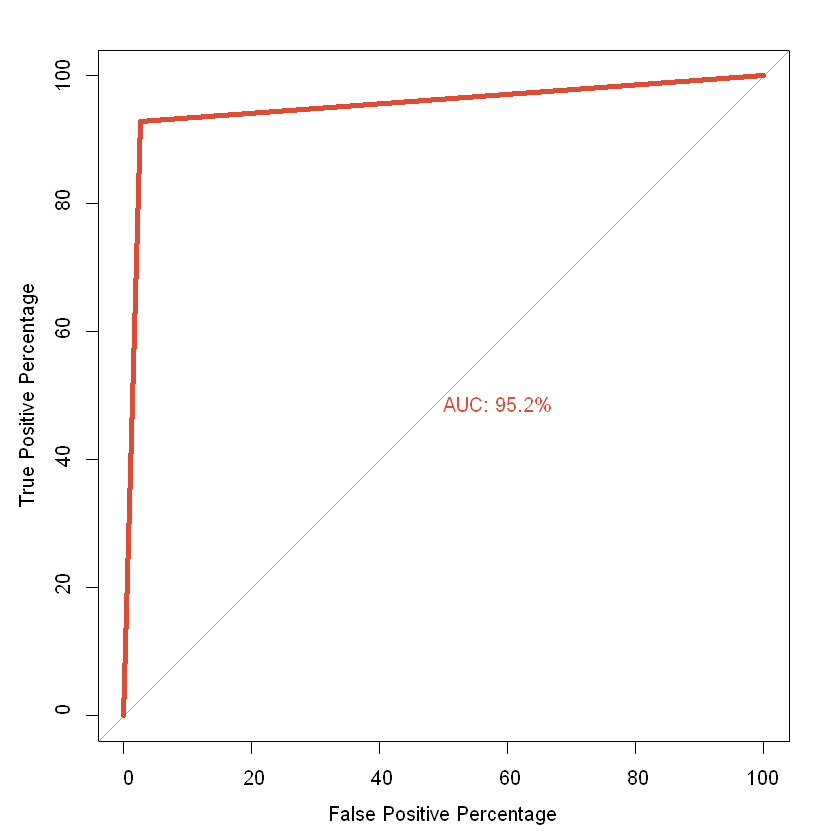

In [15]:
#Run the Random Forest model
set.seed(42)
wisc_pr_rf <- randomForest(diagnosis ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7, data = wisc_pr_train, ntree = 300)
wisc_pr_rf

#Make predictions on the test set
rf_predict <- predict(wisc_pr_rf, wisc_pr_test[,1:7], type = "response")
g <- table(rf_predict, wisc_pr_test$diagnosis)
g
sum(diag(g))/sum(g)

#Plot ROC curve
par(pty = "s")
roc(wisc_pr_test$diagnosis, as.numeric(rf_predict), plot = TRUE, legacy.axes = TRUE, percent = TRUE,
    xlab = "False Positive Percentage", ylab = "True Positive Percentage", col = "#e34a33", lwd = 4,
    print.auc = TRUE)

The random forest correctly predicts 95.8% of the test observations, with an AUC value of 95.2%.

# 7. Classifier Comparison

Setting levels: control = B, case = M

Setting direction: controls < cases




Call:
roc.default(response = wisc_pr_test$diagnosis, predictor = predicted,     percent = TRUE, plot = TRUE, legacy.axes = TRUE, xlab = "False Positive Percentage",     ylab = "True Positive Percentage", col = "#377eb8", lwd = 4,     print.auc = TRUE, print.auc.y = 60, print.auc.x = 30)

Data: predicted in 119 controls (wisc_pr_test$diagnosis B) < 71 cases (wisc_pr_test$diagnosis M).
Area under the curve: 95.77%

Setting levels: control = B, case = M

Setting direction: controls < cases

Setting levels: control = B, case = M

Setting direction: controls < cases



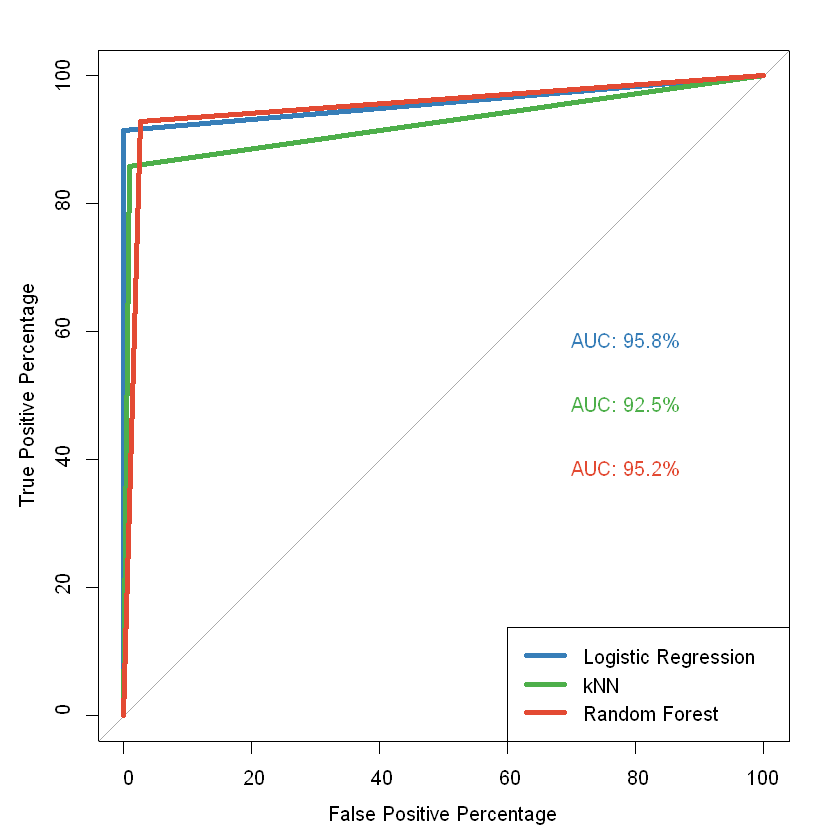

In [16]:
#Plot ROC curve for logistic regression model
#par(pty = "s")
roc(wisc_pr_test$diagnosis, predicted, plot = TRUE, legacy.axes = TRUE, percent = TRUE,
    xlab = "False Positive Percentage", ylab = "True Positive Percentage", col = "#377eb8", lwd = 4,
    print.auc = TRUE, print.auc.y = 60, print.auc.x = 30)

#Plot ROC curve for kNN classifier
plot.roc(wisc_pr_test$diagnosis, as.numeric(wisc_knn), percent = TRUE, col = "#4daf4a", lwd = 4,
    print.auc = TRUE, add = TRUE, print.auc.y = 50, print.auc.x = 30)

#Plot ROC curve for RF
plot.roc(wisc_pr_test$diagnosis, as.numeric(rf_predict), percent = TRUE, col = "#e34a33", lwd = 4,
    print.auc = TRUE, add = TRUE, print.auc.y = 40, print.auc.x = 30)

#Add legend to plot
legend("bottomright", legend = c("Logistic Regression","kNN","Random Forest"), col = c("#377eb8","#4daf4a","#e34a33"),
       lwd = 4)

The logistic regression model was the most accurate of the three models at predicting the diagnosis of new observations, with the random forest close behind. However, the classification performance of each of these classifiers is quite impressive. It is important to keep in mind that while the logistic regression model was most accurate in this case, the accuracy of each algorithm will vary depending on the selections of training and test data.

These results may be extended by attempting other classification algorithms, such as support vector machines (SVM) and neural networks.